# Chapter08 선형회귀 심화
데이터 과학을 위한 파이썬 머신러닝

- <a href="#08.1경사하강법의종류">08.1 경사하강법의 종류</a>
- <a href="#08.2과대적합과정규화">08.2 과대적합과 정규화</a>
- <a href="#08.3사이킷런을이용한선형회귀">08.3 사이킷런을 이용한 선형회귀</a>

------------------

## <a name="08.1경사하강법의종류">08.1 경사하강법의 종류</a>

### 1. 전체-배치 경사하강법(full-batch gradient descent)

### 2. 확률적 경사하강법(Stochastic Gradient Decent, SGD)
- 복잡한 알고리즘일수록 SGD가 효과적

### 3. 미니-배치 경사하강법(mini-batch gradient descent)
- **에포크(epoch)** : 데이터를 한 번에 모두 학습시키는 횟수 
<br>전체-배치 SDG를 한 번 학습하는 루프가 실행될 때 1에포크의 데이터가 학습된다고 말함
- **배치 사이즈(batch-size)** : 한 번에 학습되는 데이터의 개수
<br>총 데이터가 5012개 있고 배치 사이즈가 512라면 10번의 루프가 돌면서 1에포크를 학습했다고 말함

### 4. SGD의 파이썬 코드 작성하기

In [1]:
class LinearRegressionGD(object):
    def __init__(self, fit_intercept=True, copy_X=True,
                 eta0=0.001, epochs=1000, batch_size = 1, 
                 weight_decay=0.9, shuffle = True):
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self._eta0 = eta0
        self._epochs = epochs

        self._cost_history = []

        self._coef = None
        self._intercept = None
        self._new_X = None
        self._w_history = None
        self._weight_decay = weight_decay
        self._batch_size = batch_size
        self._is_SGD = shuffle

    def gradient(self, X, y, theta):
        return X.T.dot(self.hypothesis_function(X, theta)-y) / len(X)

    def fit(self, X, y):
        self._new_X = np.array(X)  # X 데이터 할당
        y = y.reshape(-1, 1)

        if self.fit_intercept:    # intercept 추가 여부
            # 1로만 구성된 상수항을 모든 데이터를 추가
            intercept_vector = np.ones([len(self._new_X), 1])
            self._new_X = np.concatenate(
                    (intercept_vector, self._new_X), axis=1)

        theta_init = np.random.normal(0, 1, self._new_X.shape[1])         
        # weight값 초기화
        self._w_history = [theta_init]
        self._cost_history = [self.cost(
                        self.hypothesis_function(self._new_X, theta_init), y)]

        theta = theta_init

        for epoch in range(self._epochs): # 지정된 epoch의 값만큼 학습 실행
            X_copy = np.copy(self._new_X)

            if self._is_SGD:   # stochastic 적용 여부
                np.random.shuffle(X_copy)

            batch = len(X_copy) // self._batch_size 
            # batch 사이즈를 기준으로 전체데이터를 나눔

            for batch_count  in range(batch):
                X_batch = np.copy(   # BATCH 사이즈를 기준으로 데이터를 slice
                            X_copy[batch_count * self._batch_size : (batch_count+1) & self._batch_size])

                gradient = self.gradient(X_batch  , y, theta).flatten()
                theta = theta - self._eta0 * gradient

            if epoch % 100 == 0:
                self._w_history.append(theta)
                cost = self.cost(
                    self.hypothesis_function(self._new_X, theta), y)
                self._cost_history.append(cost)
            self._eta0 = self._eta0 * self._weight_decay

        if self.fit_intercept:
            self._intercept = theta[0]
            self._coef = theta[1:]
        else:
            self._coef = theta
    def cost(self, h, y):
        return 1/(2*len(y)) * np.sum((h-y).flatten() ** 2)

    def hypothesis_function(self, X, theta):
        return X.dot(theta).reshape(-1, 1)

    def gradient(self, X, y, theta):
        return X.T.dot(self.hypothesis_function(X, theta)-y) / len(X)

    def fit(self, X, y):
        self._new_X = np.array(X)
        y = y.reshape(-1, 1)

        if self.fit_intercept:
            intercept_vector = np.ones([len(self._new_X), 1])
            self._new_X = np.concatenate(
                    (intercept_vector, self._new_X), axis=1)

        theta_init = np.random.normal(0, 1, self._new_X.shape[1])
        self._w_history = [theta_init]
        self._cost_history = [self.cost(
                        self.hypothesis_function(self._new_X, theta_init), y)]

        theta = theta_init

        for epoch in range(self._epochs):
            gradient = self.gradient(self._new_X, y, theta).flatten()
            theta = theta - self._eta0 * gradient

            if epoch % 100 == 0:
                self._w_history.append(theta)
                cost = self.cost(
                    self.hypothesis_function(self._new_X, theta), y)
                self._cost_history.append(cost)
            self._eta0 = self._eta0 * self._weight_decay

        if self.fit_intercept:
            self._intercept = theta[0]
            self._coef = theta[1:]
        else:
            self._coef = theta

    def predict(self, X):
        test_X = np.array(X)

        if self.fit_intercept:
            intercept_vector = np.ones([len(test_X), 1])
            test_X = np.concatenate(
                    (intercept_vector, test_X), axis=1)

            weights = np.concatenate(([self._intercept], self._coef), axis=0)
        else:
            weights = self._coef

        return test_X.dot(weights)

    @property
    def coef(self):
        return self._coef

    @property
    def intercept(self):
        return self._intercept

    @property
    def weights_history(self):
        return np.array(self._w_history)

    @property
    def cost_history(self):
        return self._cost_history

- 생성된 경사하강법 모델을 사용하여 학습 수행


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/train.csv")

X = df["x"].values.reshape(-1,1)
y = df["y"].values

gd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=1, shuffle=False)
bgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=len(X), shuffle=False)
sgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=1, shuffle=True)
msgd_lr = LinearRegressionGD(eta0=0.001, epochs=10000, batch_size=100, shuffle=True)

- 각 학습 결과 cost 값의 변화 : 학습 알고리즘에 따라 cost 값이 변함

In [3]:
gd_lr.fit(X, y)
bgd_lr.fit(X, y)
sgd_lr.fit(X,y)
msgd_lr.fit(X,y)


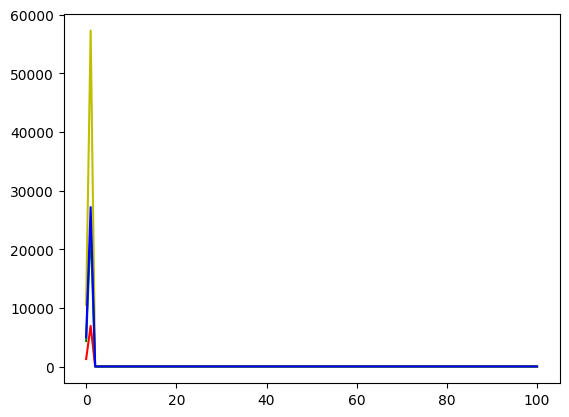

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(gd_lr.cost_history)), gd_lr.cost_history, c="r")
plt.plot(range(len(bgd_lr.cost_history)), bgd_lr.cost_history, c="y")
plt.plot(range(len(sgd_lr.cost_history)), sgd_lr.cost_history, c="g")
plt.plot(range(len(msgd_lr.cost_history)), msgd_lr.cost_history, c="b")


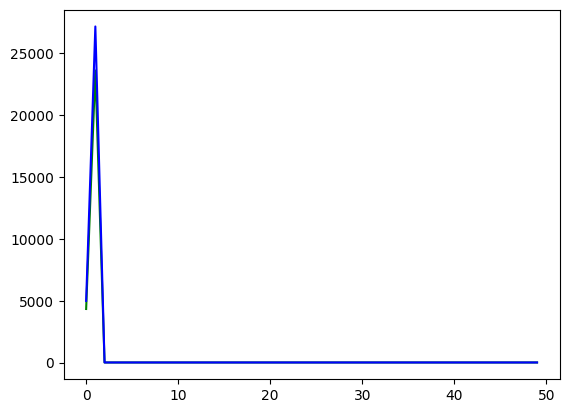

In [5]:
plt.plot(range(50), sgd_lr.cost_history[:50], c="g")
plt.plot(range(50), msgd_lr.cost_history[:50], c="b")


----------------

## <a name="08.2과대적합과정규화">08.2 과대적합과 정규화</a>

### 1. 과대적합 극복하기

- **편향(bias)** : 학습된 모델이 학습 데이터에 대해 만들어 낸 예측값과 실제값과의 차이
 - - 모델의 결과가 얼마나 한쪽으로 쏠려 있는지 나타냄
 - - 편향이 크면 학습이 잘 진행되기는 했지만 해당 데이터에만 잘 맞음
- **분산(variance)** : 학습된 모델이 테스팅 데이터에 대해 만들어 낸 예측값과 실제값과의 차이
 - - 모델의 결과가 얼마나 퍼져 있는지 나타냄
- **편향-분산 트레이드오프(bias-variance trade-off)** : 
 - - 편향과 분산의 상충관계


### 2. L2 정규화 : 리지 회귀
- 리지 회귀(ridge regression) : L2 정규화(L2 regularization)라고 부름
- 놈(norm) : 좌표평면의 원점에서 점까지의 거리를 나타내어 벡터의 크기를 측정하는 기법
-다중 회귀라고도 불리는 리지 회귀는 정규화 또는 규제화(regularization) 기법으로 알려져 있으며
- 독립 변수들 사이에 높은 상관 관계가 있는 경우 모델의 복잡성을 줄이는 데 사용. 
-'리지 회귀 페널티’로 알려진 약간의 편향, 즉  바이어스(bias)를 사용하여 모델이 과대적합(overfitting)에 덜 취약하게 만든다.

### 3. L1 정규화 : 라쏘 회귀
- 라쏘 회귀(lasso regression) L1 정규화(L1 regularization)라고 부름
- 가중치에 페널티텀을 추가하는데, 기존 수식에다 L1 놈 페널티를 추가하여 계산
- 리지 회귀와 같이 모델의 복잡성을 줄여주는 또 다른 정규화 기법,  계수 값을 0에 가깝게 만든다
- 라쏘 회귀는 필요한 요소들만 사용하고 나머지를 0으로 설정함으로써 과대적합을 방지할 수 있음

---------

## <a name="08.3사이킷런을이용한선형회귀">08.3 사이킷런을 이용한 선형회귀</a>

### 1.사이킷런과 선형회귀 관련 함수

| 함수명 |설명 | 알고리즘 |
|:------|:---|:---|
| LinearRegression | 가장 기본적인 선형회귀 알고리즘을 사용하며<br> SGD가 아닌 최자승법으로 계산한다. | 최소자승법|
| Lasso | L1 손실을 활용한 라쏘 알고리즘을 사용한다.|최소자승법|
| Ridge | L2 손실을 활용한 리지 알고리즘을 사용한다.|최소자승법|
| SGDRegressor | 확률적 경사 하강법을 사용한 회귀 모델을 만든다.<br> SGD에서 비용함수만을 변경하여 모든 함수를 지원하고 있어 <br> 필요한 하이퍼 매개변수를 설정해야 한다. |SGD|

### 2.사이킷런을 활용하여 선형회귀 구현하기

-----

THE END